# For my data project I will be taking a looking at exercise data gathered from garmin connect

In [1]:
import pandas as pd  # Used simply for loading and setting up data
import numpy as np   # Used for general array indexing
import torch
import sklearn
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib import dates as mpl_dates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import time
import os
from sklearn import linear_model
from sklearn.decomposition import TruncatedSVD

In [2]:
print(torch.has_cuda)
if torch.has_cuda:
    dev = torch.device('cuda')     # Default CUDA device
else:
    dev = torch.device('cpu')
print(dev)

False
cpu


# Milestone 1: Data Wrangling

In [3]:
from datetime import timedelta
#datar is running only data
datar = pd.read_csv("Team Running Data.csv", na_values=['--', 'inf', '-inf', 'NaN']) #all missing data is now NaN
datar = datar[datar["Activity Type"] == 'Running']
datar["Date"] = pd.to_datetime(datar.Date)
datar["Time"] = pd.to_timedelta(datar.Time)
datar["Calories"] =  pd.to_numeric(datar["Calories"], errors='coerce')
datar["Distance"] = pd.to_numeric(datar["Distance"], errors='coerce').fillna(value=0)
datar["Aerobic TE"] = pd.to_numeric(datar["Aerobic TE"], errors='coerce')
datar["Avg Run Cadence"] = pd.to_numeric(datar["Avg Run Cadence"], errors='coerce')
datar["Weight"] = pd.to_numeric(datar["Weight"], errors='coerce')
datar['HR-exists'] = datar['Avg HR'].notna() #True if HR-exists, Faslse if NaN
datar['Cal-exists'] = datar['Calories'].notna() #True if Calories exist, Faslse if NaN
datar["Seconds"] = datar.Time.dt.total_seconds().dropna()
datar["Pace_decimal"] = datar["Seconds"] / (60*datar["Distance"])
datar["Pace_decimal"] = datar["Pace_decimal"].dropna()
datar = datar[datar["Pace_decimal"] < 10]
datar = datar[datar["Distance"] > 0]
base = pd.to_timedelta("00:00:00.00")
#datar["Pace"] = (datar["Time"] - base) / (60*datar["Distance"])
datar = datar[datar["Time"] > base]

#dataxt is non running data
dataxt = pd.read_csv("Team Running Data.csv", na_values=['--', 'inf', '-inf', 'NaN']) #all missing data is now NaN
dataxt = dataxt[dataxt["Activity Type"] != 'Running']
dataxt["Date"] = pd.to_datetime(dataxt.Date)
dataxt["Time"] = pd.to_timedelta(dataxt.Time)
dataxt["Calories"] =  pd.to_numeric(dataxt["Calories"], errors='coerce')
dataxt["Distance"] = pd.to_numeric(dataxt["Distance"], errors='coerce').fillna(value=0)
dataxt["Aerobic TE"] = pd.to_numeric(dataxt["Aerobic TE"], errors='coerce')
dataxt["Weight"] = pd.to_numeric(dataxt["Weight"], errors='coerce')
dataxt['HR-exists'] = dataxt['Avg HR'].notna() #True if HR-exists, Faslse if NaN
dataxt['Cal-exists'] = dataxt['Calories'].notna() #True if Calories exist, Faslse if NaN
dataxt["Seconds"] = dataxt.Time.dt.total_seconds().dropna()

#databoth is both running and xt data
databoth = pd.concat([datar, dataxt])
datar.head()

,Name,Activity Type,Date,Title,Distance,Calories,Time,Avg HR,Aerobic TE,Avg Run Cadence,...,Elev Gain,Elev Loss,Avg Stride Length,Hieght,Weight,Location,HR-exists,Cal-exists,Seconds,Pace_decimal
0,Nels,Running,2021-03-12 14:52:00,Menomonie Running,4.01,427.0,0 days 00:27:36,156.0,3.1,177.0,...,157,154,1.32,5'10,150,Menomonie,True,True,1656.0,6.882793
1,Nels,Running,2021-03-05 14:48:00,Menomonie Running,6.02,627.0,0 days 00:42:07,155.0,3.1,184.0,...,221,214,1.25,5'10,150,Menomonie,True,True,2527.0,6.996124
2,Nels,Running,2021-03-04 14:55:00,Menomonie Running,7.15,750.0,0 days 00:45:32,166.0,3.7,183.0,...,379,376,1.38,5'10,150,Menomonie,True,True,2732.0,6.368298
3,Nels,Running,2021-03-02 14:52:00,Menomonie Running,9.08,940.0,0 days 00:57:51,166.0,4.0,184.0,...,270,266,1.37,5'10,150,Menomonie,True,True,3471.0,6.371145
4,Nels,Running,2021-03-01 14:55:00,Menomonie Running,6.53,715.0,0 days 00:44:54,161.0,3.5,185.0,...,232,226,1.27,5'10,150,Menomonie,True,True,2694.0,6.875957


Use one hot encoding for categorical data such as Name and Activity Type

In [4]:
oh_name = lb.fit_transform(datar["Name"])
oh_activity  = lb.fit_transform(datar["Activity Type"])
print(oh_name.shape)

(4163, 8)


In [5]:
#use random forest model to predict calories
criteria_cal = datar['Cal-exists'] == False
criteria_cal_true = datar['Cal-exists'] == True
cal_missing = datar[criteria_cal] #data from rows of NaN Calories
cal_not_missing  = datar[criteria_cal_true] #all data minus rows with NaN Calories


predict_cals = cal_missing[['Weight','Pace_decimal', 'Distance']]

In [6]:
Y = cal_not_missing["Calories"].values
X = cal_not_missing[['Weight','Pace_decimal', 'Distance']].values
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y, test_size = 0.2)

In [7]:
model = RandomForestRegressor(n_estimators = 100, max_depth = 15, random_state = 0)
model.fit(Xtrain, Ytrain)
cal_predict = model.predict(predict_cals)
datar.loc[~datar['Cal-exists'],['Calories']] = cal_predict

In [8]:
print("Mean Square Error (Random Forest - running calories): ", model.score(Xtest, Ytest))

Mean Square Error (Random Forest - running calories):  0.9504549030366839


In [9]:
criteria_HR = datar['HR-exists'] == False
criteria_HR_true = datar['HR-exists'] == True
HR_missing = datar[criteria_HR] #data from rows of NaN HR
HR_not_missing  = datar[criteria_HR_true] #all data minus rows with NaN HR

predict_HR = HR_missing[['Calories','Pace_decimal', 'Distance', 'Weight']] #use to predict NaN HR's

In [10]:
YHR = HR_not_missing["Avg HR"].values.astype('float32')
XHR = HR_not_missing[['Calories','Pace_decimal', 'Distance', 'Weight']].values.astype('float32')
XtrainHR, XtestHR, YtrainHR, YtestHR = train_test_split(XHR, YHR, test_size = 0.2)

In [11]:
model_HR = RandomForestRegressor(n_estimators = 200, max_depth = 20, random_state = 0)
model_HR.fit(XtrainHR, YtrainHR)
HR_predict = model_HR.predict(predict_HR)
datar.loc[~datar['HR-exists'],['Avg HR']] = HR_predict

In [12]:
print("Mean Square Error (Random Forest - running Avg HR): ", model_HR.score(XtestHR, YtestHR))

Mean Square Error (Random Forest - running Avg HR):  0.6486214657968569


In [13]:
#use random forest model to predict calories
Xcriteria_cal = dataxt['Cal-exists'] == False
Xcriteria_cal_true = dataxt['Cal-exists'] == True
Xcal_missing = dataxt[Xcriteria_cal] #data from rows of NaN Calories
Xcal_not_missing = dataxt[Xcriteria_cal_true] #all data minus rows with NaN Calories
Xpredict_cals = Xcal_missing[['Weight','Seconds', 'Distance']]

In [14]:
Y_XT = Xcal_not_missing["Calories"].values
X_XT = Xcal_not_missing[['Weight','Seconds', 'Distance']].values
Xtrain_XT, Xtest_XT, Ytrain_XT, Ytest_XT = train_test_split(X_XT,Y_XT, test_size = 0.2)

In [15]:
model_cal_XT = RandomForestRegressor(n_estimators = 200, max_depth = 20, random_state = 0)
model_cal_XT.fit(Xtrain_XT, Ytrain_XT)
cal_predict_XT = model_cal_XT.predict(Xpredict_cals)
dataxt.loc[~dataxt['Cal-exists'],['Calories']] = cal_predict_XT

In [16]:
print("Mean Square Error (Random Forest - xt calories): ", model_cal_XT.score(Xtest_XT, Ytest_XT))

Mean Square Error (Random Forest - xt calories):  0.8181733302387602


In [17]:
Xcriteria_HR = dataxt['HR-exists'] == False
Xcriteria_HR_true = dataxt['HR-exists'] == True
XHR_missing = dataxt[Xcriteria_HR] #data from rows of NaN HR
XHR_not_missing  = dataxt[Xcriteria_HR_true] #all data minus rows with NaN HR

predict_HR_XT = XHR_missing[['Calories','Seconds', 'Weight']] #use to predict NaN HR's

In [18]:
YHR_XT = XHR_not_missing["Avg HR"].values.astype('float32')
XHR_XT = XHR_not_missing[['Calories','Seconds', 'Weight']].values.astype('float32')
XtrainHR_XT, XtestHR_XT, YtrainHR_XT, YtestHR_XT = train_test_split(XHR_XT, YHR_XT, test_size = 0.2)

In [19]:
model_HR_XT = RandomForestRegressor(n_estimators = 200, max_depth = 20, random_state = 0)
model_HR_XT.fit(XtrainHR_XT, YtrainHR_XT)
HR_predict_XT = model_HR_XT.predict(predict_HR_XT)
dataxt.loc[~dataxt['HR-exists'],['Avg HR']] = HR_predict_XT

In [20]:
print("Mean Square Error (Random Forest - xt Avg HR): ", model_HR_XT.score(XtestHR_XT, YtestHR_XT))

Mean Square Error (Random Forest - xt Avg HR):  0.8878434569997449


All NaN Avg HR data and Calorie data has been filled with predicted values and are good to use

In [21]:
databoth = pd.concat([datar, dataxt])
databoth["Pace_decimal"] = databoth["Pace_decimal"].fillna(0)
databoth["Avg Run Cadence"] = databoth["Avg Run Cadence"].fillna(0)
databoth["Avg Stride Length"] = databoth["Avg Stride Length"].fillna(0)
databoth["Elev Gain"] = databoth["Elev Gain"].fillna(0)
databoth["Elev Loss"] = databoth["Elev Loss"].fillna(0)
databoth["Aerobic TE"] = databoth["Aerobic TE"].fillna(value = databoth["Aerobic TE"].mean())

# Milestone 2: Domain Comprehension

# Milestone 3: Domain Comprehension

For this milestone I'm going to be looking at my personal data as a subset of the data I collected

In [22]:
databoth["isRunning"] = databoth["Activity Type"] == 'Running'
databoth["isIndoorCycling"] = databoth["Activity Type"] == 'Indoor Cycling'
databoth["isCycling"] = databoth["Activity Type"] == 'Cycling'
databoth["isWalking"] = databoth["Activity Type"] == 'Walking'
databoth["isOther"] = databoth["Activity Type"] == 'Other'
databoth["isSwimming"] = databoth["Activity Type"] == 'Swimming'
databoth["isHiking"] = databoth["Activity Type"] == 'Hiking'
databoth["isElliptical"] = databoth["Activity Type"] == 'Elliptical'
databoth["isIndoorRunning"] = databoth["Activity Type"] == 'Indoor Running'
databoth["isTreadmilRunning"] = databoth["Activity Type"] == 'Treadmil Running'
databoth

,Name,Activity Type,Date,Title,Distance,Calories,Time,Avg HR,Aerobic TE,Avg Run Cadence,...,isRunning,isIndoorCycling,isCycling,isWalking,isOther,isSwimming,isHiking,isElliptical,isIndoorRunning,isTreadmilRunning
0,Nels,Running,2021-03-12 14:52:00,Menomonie Running,4.01,427.0,0 days 00:27:36,156.0,3.1,177.0,...,True,False,False,False,False,False,False,False,False,False
1,Nels,Running,2021-03-05 14:48:00,Menomonie Running,6.02,627.0,0 days 00:42:07,155.0,3.1,184.0,...,True,False,False,False,False,False,False,False,False,False
2,Nels,Running,2021-03-04 14:55:00,Menomonie Running,7.15,750.0,0 days 00:45:32,166.0,3.7,183.0,...,True,False,False,False,False,False,False,False,False,False
3,Nels,Running,2021-03-02 14:52:00,Menomonie Running,9.08,940.0,0 days 00:57:51,166.0,4.0,184.0,...,True,False,False,False,False,False,False,False,False,False
4,Nels,Running,2021-03-01 14:55:00,Menomonie Running,6.53,715.0,0 days 00:44:54,161.0,3.5,185.0,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6002,Mitchell,Indoor Cycling,2019-02-07 14:45:00,Indoor Cycling,0.00,404.0,0 days 00:32:22,158.0,3.5,0.0,...,False,True,False,False,False,False,False,False,False,False
6003,Mitchell,Indoor Cycling,2019-02-06 15:11:00,Indoor Cycling,0.00,391.0,0 days 01:04:14,118.0,1.6,0.0,...,False,True,False,False,False,False,False,False,False,False
6005,Mitchell,Indoor Cycling,2019-02-04 06:00:00,Indoor Cycling,0.00,188.0,0 days 00:35:06,108.0,1.3,0.0,...,False,True,False,False,False,False,False,False,False,False
6006,Mitchell,Indoor Cycling,2019-02-03 14:37:00,Indoor Cycling,0.00,120.0,0 days 00:15:03,122.0,1.3,0.0,...,False,True,False,False,False,False,False,False,False,False


In [23]:
datarEric = datar[datar["Name"] == 'Eric']
databEric = databoth[databoth["Name"] == 'Eric']

datarEric["Pace_decimal"] = datarEric["Pace_decimal"].fillna(0)
datarEric["Avg Run Cadence"] = datarEric["Avg Run Cadence"].fillna(0)
datarEric["Avg Stride Length"] = datarEric["Avg Stride Length"].fillna(0)
datarEric["Elev Gain"] = datarEric["Elev Gain"].fillna(0)
datarEric["Elev Loss"] = datarEric["Elev Loss"].fillna(0)
datarEric["Aerobic TE"] = datarEric["Aerobic TE"].fillna(value = databoth["Aerobic TE"].mean())

datarEric.sort_values('Date')
databEric.sort_values('Date')
datarEric.set_index('Date',inplace=True)
databEric.set_index('Date',inplace=True)

weekly = datarEric.resample('W').sum()
monthly = datarEric.resample('M').sum()

X_Eric = np.array(weekly.index)
Y_Eric = np.array(weekly.Distance)

<ipython-input-23-0b3d4b5e5d04>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datarEric["Pace_decimal"] = datarEric["Pace_decimal"].fillna(0)
<ipython-input-23-0b3d4b5e5d04>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datarEric["Avg Run Cadence"] = datarEric["Avg Run Cadence"].fillna(0)
<ipython-input-23-0b3d4b5e5d04>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

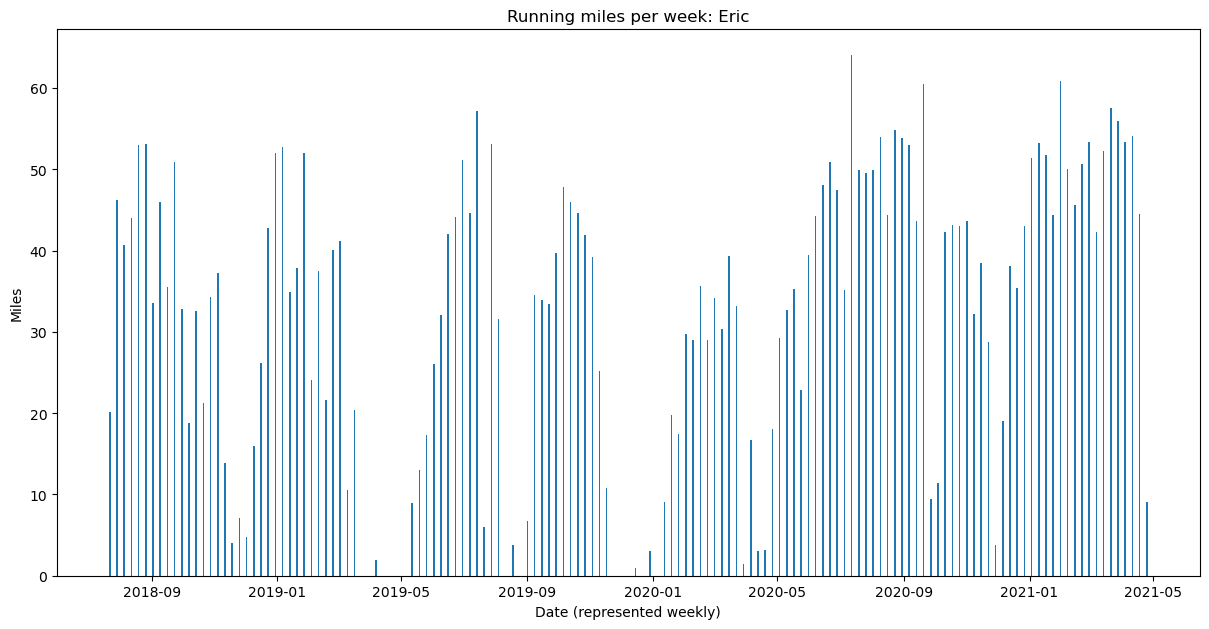

In [24]:
fig,ax = plt.subplots(1, figsize=(12,6), dpi=100)
plt.bar(X_Eric, Y_Eric, width=1.5)
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.xlabel('Date (represented weekly)')
plt.ylabel('Miles')
plt.title('Running miles per week: Eric')
plt.show()

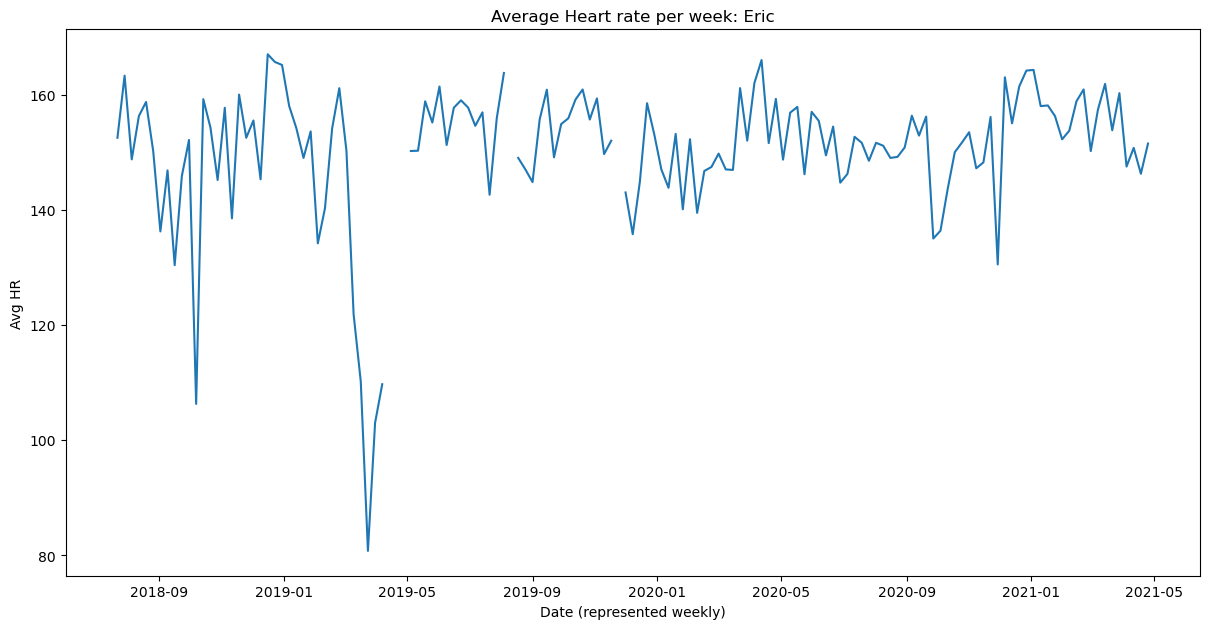

In [25]:
weekly = databEric.resample('W').mean()
monthly = databEric.resample('M').mean()
X_Eric = np.array(weekly.index)
Y_Eric = np.array(weekly["Avg HR"])
date_format = mpl_dates.DateFormatter('%m, %y')


fig,ax = plt.subplots(1, figsize=(12,6), dpi=100)
plt.plot(X_Eric, Y_Eric)
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.xlabel('Date (represented weekly)')
plt.ylabel('Avg HR')
plt.title('Average Heart rate per week: Eric')
plt.show()

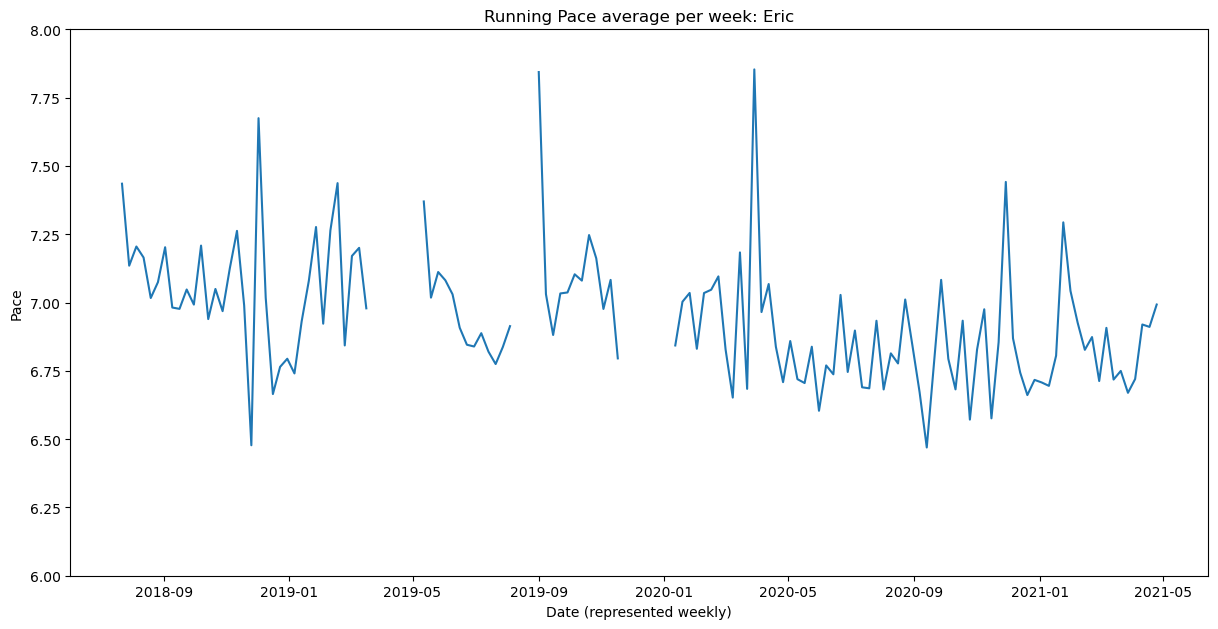

In [26]:
weekly_pace = datarEric.resample('W').mean()
X_Eric = np.array(weekly_pace.index)
Y_Eric = np.array(weekly_pace["Pace_decimal"])
date_format = mpl_dates.DateFormatter('%m, %y')
fig,ax = plt.subplots(1, figsize=(12,6), dpi=100)
plt.plot(X_Eric, Y_Eric)
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.xlabel('Date (represented weekly)')
plt.ylabel('Pace')
plt.title('Running Pace average per week: Eric')
ax.set_ylim(6, 8)
plt.show()

In [27]:
athletes = databoth["Name"]
activities = databoth["Activity Type"]
E_allActivities = databoth[databoth["Name"] == 'Eric'][["Activity Type", "isRunning", "isIndoorCycling","isCycling",
                                                        "isWalking","isOther","isSwimming","isHiking",
                                                        "isIndoorRunning","isTreadmilRunning","isElliptical"]]

E_Running = E_allActivities.isRunning.sum()
E_Cycling = E_allActivities.isCycling.sum()
E_IndoorCycling = E_allActivities.isIndoorCycling.sum()
E_TreadmilRunning = E_allActivities.isTreadmilRunning.sum()

E_total = [E_Running, E_Cycling, E_IndoorCycling, E_Other, E_TreadmilRunning]

NameError: name 'E_Other' is not defined

In [ ]:
fig,ax1 = plt.subplots(1, figsize=(5,5), dpi=100)
ax1.pie(E_total, autopct='%1.1f%%',labels = E_allActivities["Activity Type"].unique(),
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()
print(E_total)

This pie chart shows how often I recorded different activities

# Milestone 4: Classification Robustness

Let's first look at a KNN Model to classify Activity types

In [ ]:
attributes = databoth[['Avg HR', 'Calories', 'Seconds']].values
labels = databoth['Activity Type'].values

In [ ]:
attributes_train, attributes_test, labels_train, labels_test = train_test_split(attributes, labels, test_size=0.20)

In [ ]:
from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaler.fit(attributes_train)

#attributes_train = scaler.transform(attributes_train)
#attributes_test = scaler.transform(attributes_test)
print(f"shapes are {attributes_train.shape} and {labels_train.shape} and {attributes_test.shape} and {labels_test.shape}")

In [ ]:
activity_classifier = KNeighborsClassifier(n_neighbors=10)
activity_classifier.fit(attributes_train, labels_train)

In [ ]:
fig,ax = plt.subplots(2, figsize=(12,6), dpi=100)
plt.title('train - test for Avg HR')
ax[0].scatter(attributes_train[:,0], labels_train, color='green', marker='x', label="train")
ax[0].scatter(attributes_train[:,0], activity_classifier.predict(attributes_train), color='magenta', marker='o', label="pred")
ax[0].legend()
ax[1].scatter(attributes_test[:,0], labels_test, color='green', marker='x', label="test")
ax[1].scatter(attributes_test[:,0], activity_classifier.predict(attributes_test), color='magenta', marker='o', label="pred")
ax[1].legend()
ax[0].set_xlabel("Average HR")
ax[1].set_xlabel("Average HR")
plt.tight_layout()
plt.show()

In [ ]:
fig,ax = plt.subplots(2, figsize=(12,6), dpi=100)
plt.title('train - test for Calories')
ax[0].scatter(attributes_train[:,1], labels_train, color='green', marker='x', label="train")
ax[0].scatter(attributes_train[:,1], activity_classifier.predict(attributes_train), color='magenta', marker='o', label="pred")
ax[0].legend()
ax[1].scatter(attributes_test[:,1], labels_test, color='green', marker='x', label="test")
ax[1].scatter(attributes_test[:,1], activity_classifier.predict(attributes_test), color='magenta', marker='o', label="pred")
ax[1].legend()
ax[0].set_xlabel("Calories")
ax[1].set_xlabel("Calories")
plt.tight_layout()
plt.show()

In [ ]:
fig,ax = plt.subplots(2, figsize=(12,6), dpi=100)
plt.title('train - test for Time')
ax[0].scatter(attributes_train[:,2], labels_train, color='green', marker='x', label="train")
ax[0].scatter(attributes_train[:,2], activity_classifier.predict(attributes_train), color='magenta', marker='o', label="pred")
ax[0].legend()
ax[1].scatter(attributes_test[:,2], labels_test, color='green', marker='x', label="test")
ax[1].scatter(attributes_test[:,2], activity_classifier.predict(attributes_test), color='magenta', marker='o', label="pred")
ax[1].legend()
ax[0].set_xlabel("Time (Seconds)")
ax[0].set_xlabel("Time (Seconds)")
plt.tight_layout()
plt.show()

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=2020)

depths = []
scores_train = []
scores_test = []

cv_depths = []
cv_scores = []
cv_means = []



for i in range(1,100):
    T = KNeighborsClassifier(n_neighbors=i)
    T.fit(attributes_train, labels_train)
    depths.append(i)
    scores_train.append(T.score(attributes_train, labels_train))
    scores_test.append(T.score(attributes_test, labels_test))
    
    cv_depths.extend([i,i,i,i,i])
    cv_out = cross_val_score(activity_classifier, attributes, labels, cv=cv)
    cv_scores.extend(cv_out)
    cv_means.append(cv_out.mean())

print(f"CV: {cv_out.mean()}")

These plots each show how well the model predicts data based on our three attributes
For the first plot we see that it does a good job of predicting things with a lowwer heart rate. For example walking
or Other (includes things like rowing, roller skiing, yoga, etc.) is pretty distinguishable from running which generally has a higher Average Heart Rate.
The second plot is similar, One thing I notice is that there is a cutoff when distinguishing between Cycling and running. For both plots 1 and 2 Running has more data points with higher calories and heart rate.
To me the last plot looks to be the most accurate, it easily distinguishes long activities as Cycling and short activities as walking or Other.


Here is a decisionTreeClassifier that classifies Running vs Cycling based on heart rate and Calories

In [ ]:
Xg = np.array(databoth[["Calories", "Avg HR"]][databoth["Activity Type"] == 'Running'])   #Calories from Running data
Lg = np.array(databoth["Activity Type"][databoth["Activity Type"] == 'Running']) #Avg HR from running data
Xm =  np.array(databoth[["Calories", "Avg HR"]][databoth["Activity Type"] == 'Cycling']) #Calories from Cycling data
Lm =  np.array(databoth["Activity Type"][databoth["Activity Type"] == 'Cycling']) #Avg HR from Cycling data

points_all = np.concatenate([Xg,Xm])
labels_all = np.concatenate([Lg,Lm])

fig,ax = plt.subplots(1, figsize=(20,8), dpi=100)
ax.scatter(points_all[labels_all=="Running",0],
           points_all[labels_all=="Running",1],
           color='green')
ax.scatter(points_all[labels_all=="Cycling",0],
           points_all[labels_all=="Cycling",1],
           color='magenta')
ax.set_xlim(0,1010)
ax.set_ylim(0,200)
plt.show()

In [ ]:
T = tree.DecisionTreeClassifier(max_depth=7)
Xtrain,Xtest,Ltrain,Ltest = train_test_split(points_all, labels_all)

T.fit(Xtrain, Ltrain)

In [ ]:
x_min, x_max = 0, 1010 
y_min, y_max = 50, 200
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 215),
                     np.linspace(y_min, y_max, 215))
Z = T.predict(np.c_[xx.ravel(), yy.ravel()])
    
xx = xx.flatten()
yy = yy.flatten()

thecolor = []

for i in Z:
    if i == "Running":
        thecolor.append("green")
    else:
        thecolor.append("magenta")

fig,ax = plt.subplots(figsize=(10,10), dpi=100)
ax.scatter(xx, yy, alpha=0.1, color = np.array(thecolor))
ax.scatter(points_all[labels_all=="Running",0],
           points_all[labels_all=="Running",1], color = "green", label = 'Running')
ax.scatter(points_all[labels_all=="Cycling",0],
           points_all[labels_all=="Cycling",1], color = "magenta", label = 'Cycling')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_ylabel("Average Heart Rate")
ax.set_xlabel("Calories")
ax.legend(loc ='upper right')
plt.show(fig)

In [ ]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(points_all,labels_all, test_size = 0.2)

T = tree.DecisionTreeClassifier(max_depth=7)

T.fit(Xtrain,Ytrain)
ypred = T.predict(Xtest)

cv = KFold(n_splits=5, shuffle=True, random_state=2020)

depths = []
scores_train = []
scores_test = []

cv_depths = []
cv_scores = []
cv_means = []



for i in range(1,100):
    T = tree.DecisionTreeClassifier(max_depth=7)
    T.fit(Xtrain, Ytrain)
    depths.append(i)
    scores_train.append(T.score(Xtrain, Ytrain))
    scores_test.append(T.score(Xtest, Ytest))
    
    cv_depths.extend([i,i,i,i,i])
    cv_out = cross_val_score(T, points_all, labels_all, cv=cv)
    cv_scores.extend(cv_out)
    cv_means.append(cv_out.mean())

print(f"CV: {cv_out.mean()}")
print(f"R^2: {T.score(Xtest,Ytest)}")

Overall this model works pretty well, there is a little bit of over fitting I notice on the graph, but overall not too bad.
Having more Cycling data would have helped a little more.

# Mile Stone 5: Descriptive Regression

In [ ]:
pcadata = databoth.select_dtypes(np.number)
pcadata['target'] = databoth["Name"]
pcadata.drop('Time',axis='columns', inplace=True)
pcadata = pcadata.fillna(0)
features = ['Distance', 'Calories', 'Avg HR','Max HR','Aerobic TE','Avg Run Cadence', 'Avg Stride Length', 'Weight', 'Seconds', 'Pace_decimal']

pca_X = pcadata[['Distance', 'Calories', 'Avg HR','Aerobic TE','Avg Run Cadence',
                'Avg Stride Length', 'Weight', 'Seconds', 'Pace_decimal']].values
pca_Y = pcadata['target'].values

In [ ]:
pcadata

In [ ]:
pca = PCA()
principalComponents = pca.fit_transform(pca_X)

In [ ]:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

PC1 is responsible for the most variance by far, with PC 2 being the second most

In [ ]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(pca_X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pcadata[['target']]], axis = 1)

In [ ]:
pca.explained_variance_ratio_

This means that PC1 explains 98% of the variance, while PC2 explains 1.4%

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlim(-5000,15000)
ax.set_ylim(-500,1000)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Eric', 'Nels', 'Max', 'Nick', 'Matthew', 'Spencer', 'Ian', 'Mitchell']
colors = ['r', 'g', 'b', 'y','pink','orange','black', 'purple']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50, alpha =.5)
ax.legend(targets)
ax.grid()

This graph is zoomed in, exculding 3 outlier points

# Milestone 6: Predictive Regression

I am going to use different regression models to predict pace

In [ ]:
X = np.array(datarEric["Avg Stride Length"]).reshape(-1,1)
Y = np.array(datarEric["Pace_decimal"]).reshape(-1,1)
clf = tree.DecisionTreeRegressor()
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y, test_size = 0.2)

clf.fit(Xtrain,Ytrain)
ypred = clf.predict(Xtest)

cv = KFold(n_splits=5, shuffle=True, random_state=2020)

depths = []
scores_train = []
scores_test = []

cv_depths = []
cv_scores = []
cv_means = []



for i in range(1,100):
    clf = tree.DecisionTreeRegressor()
    clf.fit(Xtrain, Ytrain)
    depths.append(i)
    scores_train.append(clf.score(Xtrain, Ytrain))
    scores_test.append(clf.score(Xtest, Ytest))
    
    cv_depths.extend([i,i,i,i,i])
    cv_out = cross_val_score(clf, X, Y, cv=cv)
    cv_scores.extend(cv_out)
    cv_means.append(cv_out.mean())
print("Scores: DTree")
print(f"CV: {cv_out.mean()}")
print(f"R^2: {clf.score(Xtest,Ytest)}")

In [ ]:
fig,ax = plt.subplots(1, figsize=(12,6), dpi=100)
ax.scatter(Xtrain,  Ytrain, color='green', marker='x', label='real')
ax.scatter(Xtrain,  clf.predict(Xtrain), color='orange', marker='o', label='pred')
ax.set_title("Dtree predictions")
ax.set_ylabel("pace")
ax.set_xlabel("Average stride length")
ax.legend() 
plt.tight_layout()
plt.show()

In [ ]:
reg = linear_model.Ridge(alpha=.5, fit_intercept=True)
reg.fit(Xtrain,Ytrain)
reg.predict(Xtest)


cv = KFold(n_splits=5, shuffle=True, random_state=2020)

depths = []
scores_train = []
scores_test = []

cv_depths = []
cv_scores = []
cv_means = []



for i in range(1,100):
    reg = linear_model.Ridge()
    reg.fit(Xtrain, Ytrain)
    depths.append(i)
    scores_train.append(reg.score(Xtrain, Ytrain))
    scores_test.append(reg.score(Xtest, Ytest))
    
    cv_depths.extend([i,i,i,i,i])
    cv_out = cross_val_score(reg, X, Y, cv=cv)
    cv_scores.extend(cv_out)
    cv_means.append(cv_out.mean())
print("Scores: Ridge")    
print(f"CV: {cv_out.mean()}")
print(f"R^2: {reg.score(Xtest,Ytest)}")

In [ ]:
fig,ax = plt.subplots(1, figsize=(12,6), dpi=100)
ax.scatter(Xtrain,  Ytrain, color='green', marker='x', label='real')
ax.scatter(Xtrain,  reg.predict(Xtrain), color='orange', marker='o', label='pred')
ax.set_title("Ridge predictions")
ax.set_ylabel("pace")
ax.set_xlabel("Average stride length")
ax.legend() 
plt.tight_layout()
plt.show()

For this data set we see that a DesicionTree worked alot better than Ridge regression as can be told by the R^2 values and CV scores. Ridge fit a linear model while the DTree wasn't as linear and matched more of the noise in the data.

Now lets try and predict pace using Avg Cadence

In [ ]:
X = np.array(datarEric["Avg Run Cadence"]).reshape(-1,1)
Y = np.array(datarEric["Pace_decimal"]).reshape(-1,1)
clf = tree.DecisionTreeRegressor()
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y, test_size = 0.2)

clf.fit(Xtrain,Ytrain)
ypred = clf.predict(Xtest)

cv = KFold(n_splits=5, shuffle=True, random_state=2020)

depths = []
scores_train = []
scores_test = []

cv_depths = []
cv_scores = []
cv_means = []



for i in range(1,100):
    clf = tree.DecisionTreeRegressor()
    clf.fit(Xtrain, Ytrain)
    depths.append(i)
    scores_train.append(clf.score(Xtrain, Ytrain))
    scores_test.append(clf.score(Xtest, Ytest))
    
    cv_depths.extend([i,i,i,i,i])
    cv_out = cross_val_score(clf, X, Y, cv=cv)
    cv_scores.extend(cv_out)
    cv_means.append(cv_out.mean())
print("Scores: DTree")
print(f"CV: {cv_out.mean()}")
print(f"R^2: {clf.score(Xtest,Ytest)}")

In [ ]:
fig,ax = plt.subplots(1, figsize=(12,6), dpi=100)
ax.scatter(Xtrain,  Ytrain, color='green', marker='x', label='real')
ax.scatter(Xtrain,  clf.predict(Xtrain), color='orange', marker='o', label='pred')
ax.set_title("DTree predictions")
ax.set_ylabel("pace")
ax.set_xlabel("Average Cadence")
ax.legend() 
plt.tight_layout()
plt.show()

In [ ]:
X = np.array(datarEric["Avg Run Cadence"]).reshape(-1,1)
Y = np.array(datarEric["Pace_decimal"]).reshape(-1,1)
clf = tree.DecisionTreeRegressor()
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y, test_size = 0.2)

reg = linear_model.Ridge(alpha=.5, fit_intercept=True)
reg.fit(Xtrain,Ytrain)
reg.predict(Xtest)


cv = KFold(n_splits=5, shuffle=True, random_state=2020)

depths = []
scores_train = []
scores_test = []

cv_depths = []
cv_scores = []
cv_means = []



for i in range(1,100):
    reg = linear_model.Ridge()
    reg.fit(Xtrain, Ytrain)
    depths.append(i)
    scores_train.append(reg.score(Xtrain, Ytrain))
    scores_test.append(reg.score(Xtest, Ytest))
    
    cv_depths.extend([i,i,i,i,i])
    cv_out = cross_val_score(reg, X, Y, cv=cv)
    cv_scores.extend(cv_out)
    cv_means.append(cv_out.mean())
print("Scores: Ridge")    
print(f"CV: {cv_out.mean()}")
print(f"R^2: {reg.score(Xtest,Ytest)}")

In [ ]:
fig,ax = plt.subplots(1, figsize=(12,6), dpi=100)
ax.scatter(Xtrain,  Ytrain, color='green', marker='x', label='real')
ax.scatter(Xtrain,  reg.predict(Xtrain), color='orange', marker='o', label='pred')
ax.set_title("Ridge Predictions")
ax.set_ylabel("pace")
ax.set_xlabel("Average Cadence")
ax.legend() 
plt.tight_layout()
plt.show()

# Milestone 7: Compare using  an ensemble method, like bagging or randomforests

In [ ]:
from sklearn import ensemble

X = np.array(datarEric["Avg Stride Length"]).reshape(-1,1)
Y = np.array(datarEric["Pace_decimal"])

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y, test_size = 0.2)
clf = ensemble.GradientBoostingRegressor()
clf.fit(Xtrain, Ytrain.ravel())

clf.predict(Xtest)


cv = KFold(n_splits=5, shuffle=True, random_state=2020)

depths = []
scores_train = []
scores_test = []

cv_depths = []
cv_scores = []
cv_means = []



for i in range(1,100):
    clf = ensemble.GradientBoostingRegressor()
    clf.fit(Xtrain, Ytrain)
    depths.append(i)
    scores_train.append(clf.score(Xtrain, Ytrain))
    scores_test.append(clf.score(Xtest, Ytest))
    
    cv_depths.extend([i,i,i,i,i])
    cv_out = cross_val_score(clf, X, Y, cv=cv)
    cv_scores.extend(cv_out)
    cv_means.append(cv_out.mean())
print("Scores: GradientBoosting")    
print(f"CV: {cv_out.mean()}")
print(f"R^2: {clf.score(Xtest,Ytest)}")

In [ ]:
fig,ax = plt.subplots(1, figsize=(12,6), dpi=100)
ax.scatter(Xtrain,  Ytrain, color='green', marker='x', label='real')
ax.scatter(Xtrain,  clf.predict(Xtrain), color='orange', marker='o', label='pred')
ax.set_title("GradientBoosting Predictions: Average Stride Lenth VS Pace")
ax.set_ylabel("pace")
ax.set_xlabel("Average Stride Length")
ax.legend() 
plt.tight_layout()
plt.show()

In [ ]:
from sklearn import ensemble

X = np.array(datarEric["Avg Run Cadence"]).reshape(-1,1)
Y = np.array(datarEric["Pace_decimal"])

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y, test_size = 0.2)
clf = ensemble.GradientBoostingRegressor()
clf.fit(Xtrain, Ytrain.ravel())

clf.predict(Xtest)


cv = KFold(n_splits=5, shuffle=True, random_state=2020)

depths = []
scores_train = []
scores_test = []

cv_depths = []
cv_scores = []
cv_means = []



for i in range(1,100):
    clf = ensemble.GradientBoostingRegressor()
    clf.fit(Xtrain, Ytrain)
    depths.append(i)
    scores_train.append(clf.score(Xtrain, Ytrain))
    scores_test.append(clf.score(Xtest, Ytest))
    
    cv_depths.extend([i,i,i,i,i])
    cv_out = cross_val_score(clf, X, Y, cv=cv)
    cv_scores.extend(cv_out)
    cv_means.append(cv_out.mean())
print("Scores: GradientBoosting")    
print(f"CV: {cv_out.mean()}")
print(f"R^2: {clf.score(Xtest,Ytest)}")

In [ ]:
fig,ax = plt.subplots(1, figsize=(12,6), dpi=100)
ax.scatter(Xtrain,  Ytrain, color='green', marker='x', label='real')
ax.scatter(Xtrain,  clf.predict(Xtrain), color='orange', marker='o', label='pred')
ax.set_title("GradientBoosting Predictions: cadance VS pace")
ax.set_ylabel("pace")
ax.set_xlabel("Average Run Cadence")
ax.legend() 
plt.tight_layout()
plt.show()

Overall, GradientBoosting produced similar scores compared to DesicionTree Regression, and better scores then ridge Regression. It is a little overfit on the more outlier points, but does a good job of slicing the middle of the big cluster of data.

# Milestone 8: Descriptive Classification/Clustering

KMeans Clustering

In [ ]:
kmeans = KMeans(n_clusters=5, n_init=4)
kmeans.fit(principalDf)

In [ ]:
h = .02 
x_min, x_max = -5000, 10000
y_min, y_max = -500, 100
xx, yy = np.meshgrid(np.linspace(x_min, x_max), np.linspace(y_min, y_max))

Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower")

plt.plot(principalDf, principalDf, 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,color="w", zorder=10)
plt.title("K-means clustering on the digits dataset (PCA-reduced data) Centroids are marked with white cross")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(pca_X)
y_kmeans = kmeans.predict(pca_X)
pca_X[:, 0]

In [ ]:
plt.scatter(pca_X[:, 0], pca_X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='X', s=200, alpha=1);

# Milestone 9:Neural Networks

In [44]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
lb = LabelBinarizer()
oh = OneHotEncoder()
lb.fit(databoth.Name)

print(lb.classes_)
print()
for c in lb.classes_:
    print(f"label {c}\t is encoded as\t {lb.transform([c])}")
print()
rand = np.random.rand(10,3)
for row in rand:
    print(f"output {row} is most likely {lb.inverse_transform(row.reshape(1,-1))}")

['Eric' 'Ian' 'Matthew' 'Max' 'Mitchell' 'Nels' 'Nick' 'Spencer']

label Eric	 is encoded as	 [[1 0 0 0 0 0 0 0]]
label Ian	 is encoded as	 [[0 1 0 0 0 0 0 0]]
label Matthew	 is encoded as	 [[0 0 1 0 0 0 0 0]]
label Max	 is encoded as	 [[0 0 0 1 0 0 0 0]]
label Mitchell	 is encoded as	 [[0 0 0 0 1 0 0 0]]
label Nels	 is encoded as	 [[0 0 0 0 0 1 0 0]]
label Nick	 is encoded as	 [[0 0 0 0 0 0 1 0]]
label Spencer	 is encoded as	 [[0 0 0 0 0 0 0 1]]

output [0.49267744 0.06522169 0.33578588] is most likely ['Eric']
output [0.74874406 0.62093561 0.1010064 ] is most likely ['Eric']
output [0.36411429 0.16992789 0.82526054] is most likely ['Matthew']
output [0.21227119 0.35001754 0.43483532] is most likely ['Matthew']
output [0.40944207 0.38399959 0.5066296 ] is most likely ['Matthew']
output [0.69466776 0.35717243 0.11642555] is most likely ['Eric']
output [0.31618976 0.44744251 0.24144531] is most likely ['Ian']
output [0.87933774 0.94774309 0.57416935] is most likely ['Ian']
output [0.262

In [29]:
predictors = ['Activity Type','Date','Title','Distance'
              'Calories','Avg HR','Elev Gain','Elev Loss','Avg Stride Length'
              ,'Location', 'Seconds', 'Pace_decimal']
class_column = 'Name'

n_predictors = len(predictors)
print(f"{n_predictors} input variables:  {predictors}")

11 input variables:  ['Activity Type', 'Date', 'Title', 'DistanceCalories', 'Avg HR', 'Elev Gain', 'Elev Loss', 'Avg Stride Length', 'Location', 'Seconds', 'Pace_decimal']


In [30]:
lb.fit(databoth["Activity Type"])

print(lb.classes_)
print()
for c in lb.classes_:
    print(f"label {c}\t is encoded as\t {lb.transform([c])}")
print()
rand = np.random.rand(10,3)
for row in rand:
    print(f"output {row} is most likely {lb.inverse_transform(row.reshape(1,-1))}")

['Cycling' 'Elliptical' 'Hiking' 'Indoor Cycling' 'Indoor Running' 'Other'
 'Running' 'Swimming' 'Treadmill Running' 'Walking']

label Cycling	 is encoded as	 [[1 0 0 0 0 0 0 0 0 0]]
label Elliptical	 is encoded as	 [[0 1 0 0 0 0 0 0 0 0]]
label Hiking	 is encoded as	 [[0 0 1 0 0 0 0 0 0 0]]
label Indoor Cycling	 is encoded as	 [[0 0 0 1 0 0 0 0 0 0]]
label Indoor Running	 is encoded as	 [[0 0 0 0 1 0 0 0 0 0]]
label Other	 is encoded as	 [[0 0 0 0 0 1 0 0 0 0]]
label Running	 is encoded as	 [[0 0 0 0 0 0 1 0 0 0]]
label Swimming	 is encoded as	 [[0 0 0 0 0 0 0 1 0 0]]
label Treadmill Running	 is encoded as	 [[0 0 0 0 0 0 0 0 1 0]]
label Walking	 is encoded as	 [[0 0 0 0 0 0 0 0 0 1]]

output [0.52612978 0.89900746 0.15720645] is most likely ['Elliptical']
output [0.25176596 0.13825672 0.0675244 ] is most likely ['Cycling']
output [0.7452776  0.06457425 0.36593555] is most likely ['Cycling']
output [0.0689981  0.50815535 0.04484011] is most likely ['Elliptical']
output [0.41969489 0.73

In [31]:
lb.fit(databoth["Location"])

print(lb.classes_)
print()
for c in lb.classes_:
    print(f"label {c}\t is encoded as\t {lb.transform([c])}")
print()
rand = np.random.rand(10,3)
for row in rand:
    print(f"output {row} is most likely {lb.inverse_transform(row.reshape(1,-1))}")

['10' '3K' '5' '5x1K' 'Allouez' 'Amberg' 'Anson' 'Apple' 'Baraboo'
 'Beloit' 'Benton' 'Brookfield' 'Burlington' 'CCI1' 'CD' 'CF9' 'CRe10'
 'CRe9' 'Chicog' 'Clearfield' 'Cloverland' 'Cocoa' 'Colfax' 'Cook'
 'Corcoran' 'Core' 'Corn' 'Crook' 'Cycling' 'Dakota' 'De' 'Delafield'
 'Delton' 'Dog' 'Dousman' 'Dunn' 'Eagan' 'Eagle' 'Eau' 'Ellipti-Go'
 'Elliptical' 'Elroy' 'Farmington' 'For' 'Genesee' 'Germantown' 'Goodhue'
 'Green' 'Hoffman' 'Howard' 'Hudson' 'Indoor' 'Inver' 'Itasca'
 'Janesville' 'Jeffersontown' 'Kandiyohi' 'Kenosha' 'Kettlebell' 'La'
 'LaCrosse' 'Lake' 'Lakeville' 'Land' 'Lincoln' 'Lindina' 'Little'
 'Louisville' 'Lucas' 'Marshfield' 'Mauston' 'Menomonie' 'Merton' 'Middle'
 'Mile' 'Minneapolis' 'Minocqua' 'Morning' 'Move' 'Mukwonago' 'Muskego'
 'Naperville' 'Nashotah' 'Necedah' 'Neshkoro' 'New' 'Northfield'
 'Oconomowoc' 'Oshkosh' 'Other' 'Ottawa' 'Peru' 'Platteville' 'Plymouth'
 'Polmero' 'Red' 'Reedsburg' 'Relax' 'Rib' 'Rice' 'Ripon' 'River'
 'Rockford' 'Rosemount' 'Running

In [48]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(databoth.Name)

print(le.classes_)
print()
for c in le.classes_:
    print(f"label {c}\t is encoded as\t {le.transform([c])}")
print()

rand = np.random.randint(0,3, size=(10,1))
for row in rand:
    print(f"output {row} is {le.inverse_transform(row)}")

ValueError: Expected 2D array, got 1D array instead:
array=['Nels' 'Nels' 'Nels' ... 'Mitchell' 'Mitchell' 'Mitchell'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [33]:
le.fit(databoth["Activity Type"])

print(le.classes_)
print()
for c in le.classes_:
    print(f"label {c}\t is encoded as\t {le.transform([c])}")
print()

rand = np.random.randint(0,3, size=(10,1))
for row in rand:
    print(f"output {row} is {le.inverse_transform(row)}")

['Cycling' 'Elliptical' 'Hiking' 'Indoor Cycling' 'Indoor Running' 'Other'
 'Running' 'Swimming' 'Treadmill Running' 'Walking']

label Cycling	 is encoded as	 [0]
label Elliptical	 is encoded as	 [1]
label Hiking	 is encoded as	 [2]
label Indoor Cycling	 is encoded as	 [3]
label Indoor Running	 is encoded as	 [4]
label Other	 is encoded as	 [5]
label Running	 is encoded as	 [6]
label Swimming	 is encoded as	 [7]
label Treadmill Running	 is encoded as	 [8]
label Walking	 is encoded as	 [9]

output [1] is ['Elliptical']
output [0] is ['Cycling']
output [2] is ['Hiking']
output [1] is ['Elliptical']
output [1] is ['Elliptical']
output [2] is ['Hiking']
output [1] is ['Elliptical']
output [1] is ['Elliptical']
output [1] is ['Elliptical']
output [1] is ['Elliptical']


In [34]:
le.fit(databoth["Location"])

print(le.classes_)
print()
for c in le.classes_:
    print(f"label {c}\t is encoded as\t {le.transform([c])}")
print()

rand = np.random.randint(0,3, size=(10,1))
for row in rand:
    print(f"output {row} is {le.inverse_transform(row)}")

['10' '3K' '5' '5x1K' 'Allouez' 'Amberg' 'Anson' 'Apple' 'Baraboo'
 'Beloit' 'Benton' 'Brookfield' 'Burlington' 'CCI1' 'CD' 'CF9' 'CRe10'
 'CRe9' 'Chicog' 'Clearfield' 'Cloverland' 'Cocoa' 'Colfax' 'Cook'
 'Corcoran' 'Core' 'Corn' 'Crook' 'Cycling' 'Dakota' 'De' 'Delafield'
 'Delton' 'Dog' 'Dousman' 'Dunn' 'Eagan' 'Eagle' 'Eau' 'Ellipti-Go'
 'Elliptical' 'Elroy' 'Farmington' 'For' 'Genesee' 'Germantown' 'Goodhue'
 'Green' 'Hoffman' 'Howard' 'Hudson' 'Indoor' 'Inver' 'Itasca'
 'Janesville' 'Jeffersontown' 'Kandiyohi' 'Kenosha' 'Kettlebell' 'La'
 'LaCrosse' 'Lake' 'Lakeville' 'Land' 'Lincoln' 'Lindina' 'Little'
 'Louisville' 'Lucas' 'Marshfield' 'Mauston' 'Menomonie' 'Merton' 'Middle'
 'Mile' 'Minneapolis' 'Minocqua' 'Morning' 'Move' 'Mukwonago' 'Muskego'
 'Naperville' 'Nashotah' 'Necedah' 'Neshkoro' 'New' 'Northfield'
 'Oconomowoc' 'Oshkosh' 'Other' 'Ottawa' 'Peru' 'Platteville' 'Plymouth'
 'Polmero' 'Red' 'Reedsburg' 'Relax' 'Rib' 'Rice' 'Ripon' 'River'
 'Rockford' 'Rosemount' 'Running

In [42]:
databoth['Name_Index'] = le.transform(databoth['Name'])
# add a column for each of the class values, like (1,0,0) (0,1,0) (0,0,1)
for c in lb.classes_:
    databoth[f"Name_{c}"] = lb.transform(databoth['Name'])@lb.transform(np.array([[c]])).T
databoth

ValueError: y contains previously unseen labels: 'Nels'